# **Breast Cancer - Grad-CAM Project**

Dataset link: https://web.inf.ufpr.br/vri/databases/breast-cancer-histopathological-database-breakhis/

In this project the Magnification factor is 400x.

## **Instalando as Bibliotecas** 

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import os
import pathlib
import warnings

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation, Dropout
from tensorflow.keras import Sequential

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU detected.')
else:
    print(f'Default GPU device: {tf.test.gpu_device_name()}')

Default GPU device: /device:GPU:0


In [22]:
# !nvidia-smi

## Get the Data 

In [6]:
# import zipfile
    
# # Unzip the download file
# zip_ref = zipfile.ZipFile('BreaKHis_v1.tar')
# zip_ref.extractall()
# zip_ref.close()

In [7]:
import tarfile

# Unzip the download file
my_tar = tarfile.open('BreaKHis_v1.tar.gz')
my_tar.extractall() # specify which folder to extract to
my_tar.close()

## Multi-class Image Classification: Let's break it down

1. Become one with the data (visualize, visualize, visualize)
2. preprocess the data (prepare it for our model, the main step here is scaling/normalizing and turning out data into batches)
3. Create a model (start with a baseline)
4. Fit the model
5. Evaluate the model
6. Adjust different parameters and improve the model (try to beat our baseline)
7. Repeat until satisfied (experiment, experiment, experiment)

## 1. Become One with the Data 

### Inspecting the Data 

In [23]:
# %ls BreaKHis_v1
# %ls BreaKHis_v1\Experimento_1\

In [6]:
num_images = len(os.listdir('BreaKHis_v1/Experimento_1/'))

for dirpath, dirnames, filenames in os.walk('BreaKHis_v1/Experimento_1/'):
    print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.')

There are 2 directories and 2 images in BreaKHis_v1/Experimento_1/.
There are 8 directories and 0 images in BreaKHis_v1/Experimento_1/Test.
There are 0 directories and 25 images in BreaKHis_v1/Experimento_1/Test\adenosis.
There are 0 directories and 196 images in BreaKHis_v1/Experimento_1/Test\ductal_carcinoma.
There are 0 directories and 52 images in BreaKHis_v1/Experimento_1/Test\fibroadenoma.
There are 0 directories and 28 images in BreaKHis_v1/Experimento_1/Test\lobular_carcinoma.
There are 0 directories and 39 images in BreaKHis_v1/Experimento_1/Test\mucinous_carcinoma.
There are 0 directories and 32 images in BreaKHis_v1/Experimento_1/Test\papillary_carcinoma.
There are 0 directories and 26 images in BreaKHis_v1/Experimento_1/Test\phyllodes_tumor.
There are 0 directories and 31 images in BreaKHis_v1/Experimento_1/Test\tubular_adenoma.
There are 8 directories and 0 images in BreaKHis_v1/Experimento_1/Train.
There are 0 directories and 78 images in BreaKHis_v1/Experimento_1/Train\a

In [7]:
data_dir_train = pathlib.Path('BreaKHis_v1/Experimento_1/Train/')

# created a list of class_names from the subdirectory /train
class_names = np.array(sorted([item.name for item in data_dir_train.glob('*')]))
print(f'Types: {class_names}')

Types: ['adenosis' 'ductal_carcinoma' 'fibroadenoma' 'lobular_carcinoma'
 'mucinous_carcinoma' 'papillary_carcinoma' 'phyllodes_tumor'
 'tubular_adenoma']


### Visualizing Images

In [8]:
# os.listdir('BreaKHis_v1/Experimento_1/Train/benign/adenosis/')

In [8]:
# Visualizing images

def view_random_image(target_dir, target_class):
    # setup the target directory
    target_folder = target_dir + target_class
    
    # get a random image path
    random_image = random.sample(os.listdir(target_folder), 1)
    print(random_image)
    
    # read in the image and plot using matplotlib
    img = mpimg.imread(target_folder + '/' + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis('off')
    
    print(f'Image shape: {img.shape}')
    
    return img

['SOB_B_A-14-22549G-400-008.png']
Image shape: (460, 700, 3)
['SOB_B_F-14-23222AB-400-001.png']
Image shape: (460, 700, 3)
['SOB_B_PT-14-21998AB-400-038.png']
Image shape: (460, 700, 3)
['SOB_B_TA-14-13200-400-003.png']
Image shape: (460, 700, 3)


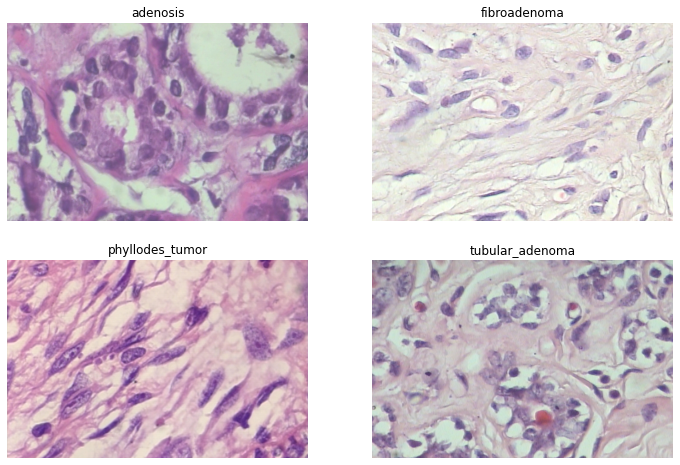

In [9]:
# view a random set of images from the training benign-dataset

plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
img1 = view_random_image(target_dir='BreaKHis_v1/Experimento_1/Train/', target_class='adenosis')

plt.subplot(2,2,2)
img2 = view_random_image(target_dir='BreaKHis_v1/Experimento_1/Train/', target_class='fibroadenoma')

plt.subplot(2,2,3)
img3 = view_random_image(target_dir='BreaKHis_v1/Experimento_1/Train/', target_class='phyllodes_tumor')

plt.subplot(2,2,4)
img4 = view_random_image(target_dir='BreaKHis_v1/Experimento_1/Train/', target_class='tubular_adenoma')

['SOB_M_DC-14-18650-400-005.png']
Image shape: (460, 700, 3)
['SOB_M_LC-14-15570-400-033.png']
Image shape: (460, 700, 3)
['SOB_M_MC-14-18842D-400-007.png']
Image shape: (460, 700, 3)
['SOB_M_PC-14-9146-400-014.png']
Image shape: (460, 700, 3)


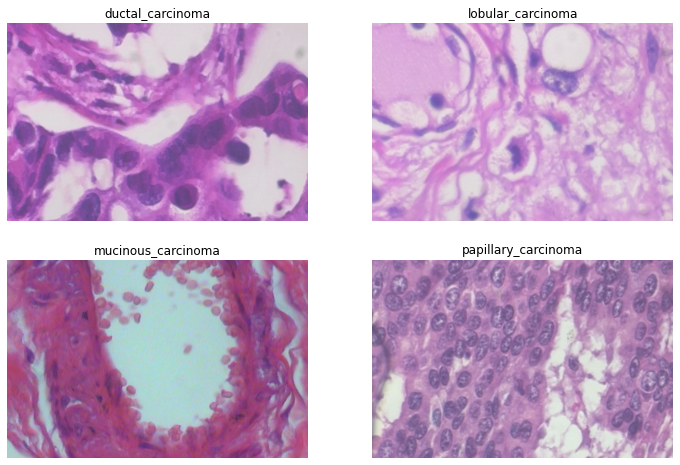

In [10]:
# view a random set of images from the training malignant-dataset

plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
img1 = view_random_image(target_dir='BreaKHis_v1/Experimento_1/Train/', target_class='ductal_carcinoma')

plt.subplot(2,2,2)
img2 = view_random_image(target_dir='BreaKHis_v1/Experimento_1/Train/', target_class='lobular_carcinoma')

plt.subplot(2,2,3)
img3 = view_random_image(target_dir='BreaKHis_v1/Experimento_1/Train/', target_class='mucinous_carcinoma')

plt.subplot(2,2,4)
img4 = view_random_image(target_dir='BreaKHis_v1/Experimento_1/Train/', target_class='papillary_carcinoma')

In [11]:
# setting up the train and test directories

train_dir = 'BreaKHis_v1/Experimento_1/Train/'
test_dir = 'BreaKHis_v1/Experimento_1/Test/'

## 2. Preprocess the Data (Prepare it for the model)

In [12]:
# Rescale
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Load data in from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir, target_size=(224,224), batch_size=32,
                                              class_mode='categorical')
test_data = test_datagen.flow_from_directory(test_dir, target_size=(224,224), batch_size=32,
                                            class_mode='categorical')

Found 1365 images belonging to 8 classes.
Found 429 images belonging to 8 classes.


## 3. Create a Model (start with a baseline)

Take the model from the CNN explainer website and test it here.

In [ ]:
# create our model
model = Sequential([
    Conv2D(10,3,input_shape=(224,224,3), activation='relu'),
    Conv2D(10,3, activation='relu'),
    MaxPool2D(),
    
    Conv2D(10,3, activation='relu'),
    Conv2D(10,3, activation='relu'),
    MaxPool2D(),
    
    Flatten(),
    Dense(8,activation='softmax')
])

# compile our model
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 220, 220, 10)      910       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 110, 110, 10)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 108, 108, 10)      910       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 106, 106, 10)      910       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 53, 53, 10)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 28090)            

## 4. Fit a Model 

In [19]:
# fit the model

history = model.fit(train_data, epochs=15, steps_per_epoch=len(train_data), validation_data=test_data,
                   validation_steps=len(test_data))

Epoch 1/15
43/43 [==============================] - 27s 625ms/step - loss: 1.4265 - accuracy: 0.4491 - val_loss: 1.6644 - val_accuracy: 0.4429
Epoch 2/15
43/43 [==============================] - 25s 587ms/step - loss: 1.1638 - accuracy: 0.5663 - val_loss: 1.7460 - val_accuracy: 0.4266
Epoch 3/15
43/43 [==============================] - 26s 611ms/step - loss: 0.8924 - accuracy: 0.6967 - val_loss: 2.0673 - val_accuracy: 0.4219
Epoch 4/15
43/43 [==============================] - 27s 616ms/step - loss: 0.5875 - accuracy: 0.8227 - val_loss: 2.2337 - val_accuracy: 0.4079
Epoch 5/15
43/43 [==============================] - 26s 611ms/step - loss: 0.3460 - accuracy: 0.9136 - val_loss: 2.7378 - val_accuracy: 0.3916
Epoch 6/15
43/43 [==============================] - 28s 653ms/step - loss: 0.2242 - accuracy: 0.9421 - val_loss: 3.3831 - val_accuracy: 0.3776
Epoch 7/15
43/43 [==============================] - 27s 626ms/step - loss: 0.1387 - accuracy: 0.9692 - val_loss: 3.1886 - val_accuracy: 0.3450

## 5. Evaluate the Model 

In [17]:
# Plot the validation and training curvers separately

def plot_loss_curves(history):
    """
    Returns separated loss curves for training and validation metrics.
    """
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    epochs = range(len(history.history['loss'])) # how many epochs did we run for?
    
    plt.figure(figsize=(14,4))
    
    # plot loss
    plt.subplot(1,2,1)
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='validation_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    
    #plot accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, accuracy, label='accuracy')
    plt.plot(epochs, val_accuracy, label='validation_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

In [20]:
# Evaluate on the test data
model.evaluate(test_data)

14/14 [==============================] - 6s 394ms/step - loss: 4.7761 - accuracy: 0.4056


[4.776148796081543, 0.4055944085121155]

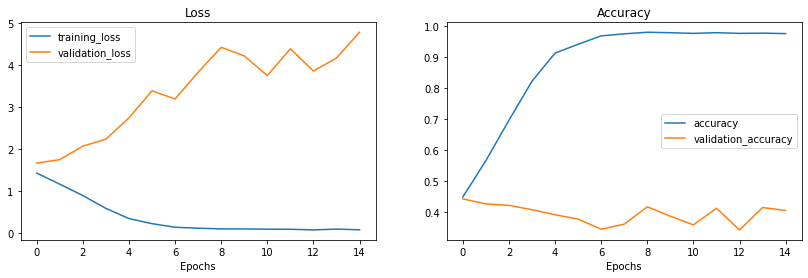

In [21]:
plot_loss_curves(history)

## 6. Adjust the model hyperparameters (to beat the baseline/ reduce overfitting) 